In [1]:
import numpy as np
from glob import glob
from tqdm import tqdm
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, f1_score
workdir = os.path.normpath("/Users/laurasanchis/PycharmProjects/2021-topic-04-team-05/")
IMGSIZE = 200

In [2]:
def compute_cost(W, X, Y):
    # calculate hinge loss
    N = X.shape[0]
    distances = 1 - Y * (np.dot(X, W))
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge_loss = regularization_strength * (np.sum(distances) / N)

    # calculate cost
    cost = 1 / 2 * np.dot(W, W) + hinge_loss
    return cost

def calculate_cost_gradient(W, X_batch, Y_batch):
    # if only one example is passed (eg. in case of SGD)
    if type(Y_batch) == np.float64:
        Y_batch = np.array([Y_batch])
        X_batch = np.array([X_batch])  # gives multidimensional array

    distance = 1 - (Y_batch * np.dot(X_batch, W))
    dw = np.zeros(len(W))

    for ind, d in enumerate(distance):
        if max(0, d) == 0:
            di = W
        else:
            di = W - (regularization_strength * Y_batch[ind] * X_batch[ind])
        dw += di

    dw = dw/len(Y_batch)  # average
    return dw

def sgd(features, outputs):
    max_epochs = 5000
    weights = np.zeros(features.shape[1])
    weights = np.random.random(features.shape[1])
    nth = 0
    prev_cost = float("inf")
    cost_threshold = 0.005  # Lower -> Longer training and better results
    history_cost = []
    # stochastic gradient descent
    for epoch in range(1, max_epochs):
        # shuffle to prevent repeating update cycles
        X, Y = shuffle(features, outputs)
        for ind, x in enumerate(X):
            ascent = calculate_cost_gradient(weights, x, Y[ind])
            weights = weights - (learning_rate * ascent)

        cost = compute_cost(weights, features, outputs)
        history_cost.append(cost)
        # convergence check on 2^nth epoch
        if epoch == 2 ** nth or epoch == max_epochs - 1:
            #cost = compute_cost(weights, features, outputs)
            print("Epoch is: {} and Cost is: {}".format(epoch, cost))
            # stoppage criterion
            if abs(prev_cost - cost) < cost_threshold * prev_cost:
                return weights, history_cost
            prev_cost = cost
            nth += 1

    return weights, history_cost

In [3]:
def processImage(image_path, imgSize):
    img = io.imread(image_path)
    img = resize(img, (imgSize, imgSize))
    img = img.reshape(-1, 1)
    bias_term = np.ones(img.shape[0]).reshape(-1, 1)
    return np.hstack([img, bias_term])

def processMask(image_path, imgSize):
    img = io.imread(image_path)
    img = resize(img, (imgSize, imgSize))
    img[img > 0] = 1
    img[img < 1] = -1
    img = img.flatten()
    return img

def predict(imageIndex):
    data = processImage(imgs[imageIndex], IMGSIZE)
    prediction = [np.sign(np.dot(data[pixelN], W)) for pixelN in range(data.shape[0])]
    groundTruth = processMask(masks[imageIndex], IMGSIZE)
    return prediction, groundTruth

def pred2Image(prediction):
    prediction = np.array(prediction)
    return prediction.reshape((IMGSIZE, IMGSIZE))

imgs = glob(workdir + "/Data/N2DH-GOWT1/img/*.tif")
masks = glob(workdir + "/Data/N2DH-GOWT1/gt/tif/*.tif")
print(f"{len(imgs)} images detected and {len(masks)} masks detected")

6 images detected and 6 masks detected


In [4]:
NImagesTraining = 4
X_train = np.vstack([processImage(imgPath, IMGSIZE) for imgPath in imgs[:NImagesTraining]])
y_train = np.concatenate([processMask(imgPath, IMGSIZE) for imgPath in masks[:NImagesTraining]])
X_test = [processImage(imgPath, IMGSIZE) for imgPath in imgs[NImagesTraining:]]
y_test = [processMask(imgPath, IMGSIZE) for imgPath in masks[:NImagesTraining]]

In [5]:
regularization_strength = 10000
learning_rate = 0.0000001
W, hist = sgd(X_train, y_train)

Epoch is: 1 and Cost is: 1816.530543018501
Epoch is: 2 and Cost is: 1803.8270959628107
Epoch is: 4 and Cost is: 1802.7716214099692


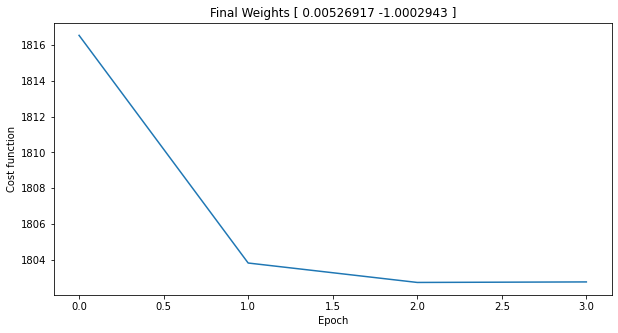

In [6]:
fig = plt.plot(hist)
_ = plt.ylabel("Cost function")
_ = plt.xlabel("Epoch")
_ = plt.title(f"Final Weights {W}")

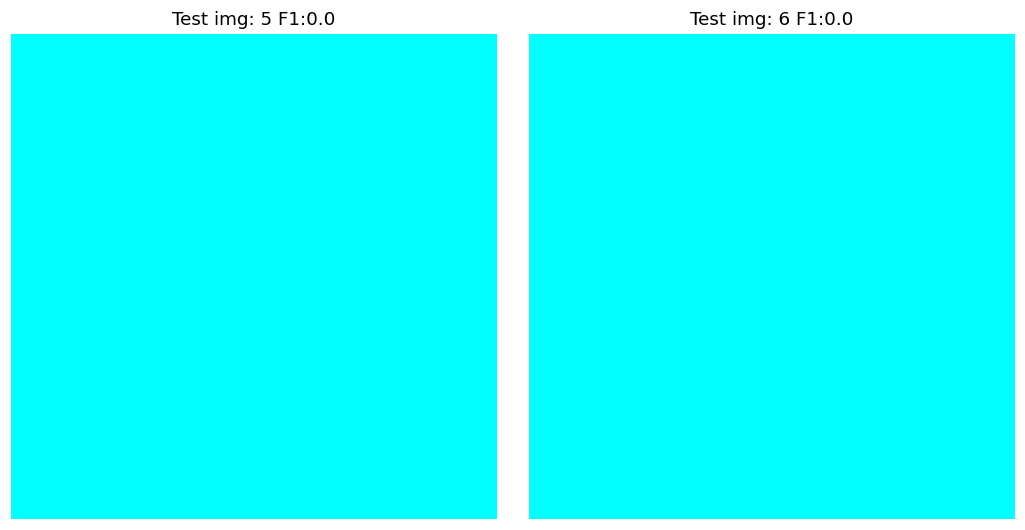

In [7]:
Ntest = len(imgs) - NImagesTraining
fig, ax = plt.subplots(ncols=Ntest, dpi=110)
fig.tight_layout(w_pad=-2)
for i in range(Ntest):
    ii = i+NImagesTraining
    pred, gt = predict(ii)
    ax[i].imshow(pred2Image(pred), cmap='cool')
    ax[i].axis('Off')
    ax[i].set_title(f"Test img: {ii+1} F1:{round(f1_score(gt, pred), 2)}")